In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import fitsio
from astropy.coordinates import SkyCoord
import astropy.units as u
import random
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from Secrest_dipole import SecrestDipole
from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

### FUNCTIONS

In [3]:
def plot_map(map_to_plot, figsize=(12,4), **plot_kwargs):
    fig = plt.figure(figsize=figsize)
    projview(map_to_plot, coord=['C','G'], graticule=True, graticule_labels=True, fig=fig, sub=(1,2,1),
             **plot_kwargs)
    tools.label_coord(plt.gca(), 'Galactic')

In [4]:
def Cells_from_alms_fit(datamap, Cinv, max_ell, idx_to_fit=None, return_alms=False):
    """
    Performs a linear least-squares fit to a healpix density map to get best-fit spherical harmonic amplitudes alm.
    Regularize by setting masked pixels (NaN or hp.UNSEEN) to zero counts and assuming `Cinv=1`.
    Returns the Cells as computed from the alms (sum of |alms|^2).
    
    """
    assert datamap.shape == Cinv.shape
    assert datamap.ndim == Cinv.ndim == 1
    
    # get number of pixels from input data map
    NPIX = len(datamap)
    
    # construct Ylm templates -> design matrix
    ells = np.arange(0, max_ell+1)
    templates = construct_templates(ells, hp.npix2nside(NPIX))
    A = templates.T
    
    # indices to fit: non-NaN, non-hp.UNSEEN, non-zero
    if idx_to_fit is None:
        idx_to_fit = np.full(NPIX, True).astype(bool)
    else:
        idx_to_fit = idx_to_fit
    idx_to_fit = idx_to_fit & (datamap != 0) & (~np.isnan(datamap)) & (datamap != hp.UNSEEN)
    map_to_fit, A_fit, Cinv_fit = datamap.copy(), A.copy(), Cinv.copy()
    
    # perform the regression: bestfit_pars are the alms
    bestfit_pars, bestfit_Cinv = tools.lstsq(map_to_fit, A_fit, Cinv_fit)
    Cells = compute_Cells(bestfit_pars)
    
    if return_alms == True:
        return ells, Cells, bestfit_pars
    else:
        return ells, Cells

### load samples

In [5]:
NSIDE = 64  # healpix resolution

In [6]:
# CatWISE overdensity map

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, save_tag='_r1.0', load_init=True)
d = SecrestDipole(**catwise_kwargs)
d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# GET OVERDENSITIES
overdensity_map_catwise = masked_datamap / np.nanmean(masked_datamap) - 1

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [7]:
# Quaia

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False)
d = SecrestDipole(**quaia_kwargs)
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
masked_datamap = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

# GET OVERDENSITIES
# mean density of the map: mean of the _expected_ counts
mean_density = np.nanmean(masked_datamap[selfunc>0] / selfunc[selfunc>0])

# then the overdensity map is
overdensity_map_quaia = np.divide(masked_datamap, selfunc, where=(selfunc>0),
                            out=np.full_like(masked_datamap, np.nan)) / mean_density - 1
                    # (fancy divide to avoid RuntimeWarnings where completeness goes to zero)

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [19]:
# 1. get the mean density of the map
mu = np.nansum((masked_datamap * selfunc)[selfunc > 0.5]) / np.nansum((selfunc * selfunc)[selfunc > 0.5])
mu

26.951186273003795

In [25]:
np.sum(selfunc > .5) / len(selfunc)

0.58966064453125

In [22]:
max(selfunc)

0.7873269787302883

In [24]:
np.nanmean(masked_datamap[selfunc > 0.7])

24.068116188211313

In [20]:
np.nanmean((masked_datamap / selfunc)[selfunc > 0.5])

/state/partition1/job-43045223/ipykernel_2238623/1367687390.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean((masked_datamap / selfunc)[selfunc > 0.5])


33.63190694514303

In [23]:
# 2. get the expected number density of quasars in each healpixel
N_expected = mu * selfunc

# what assumptions does this make about how selfunc is normalized???

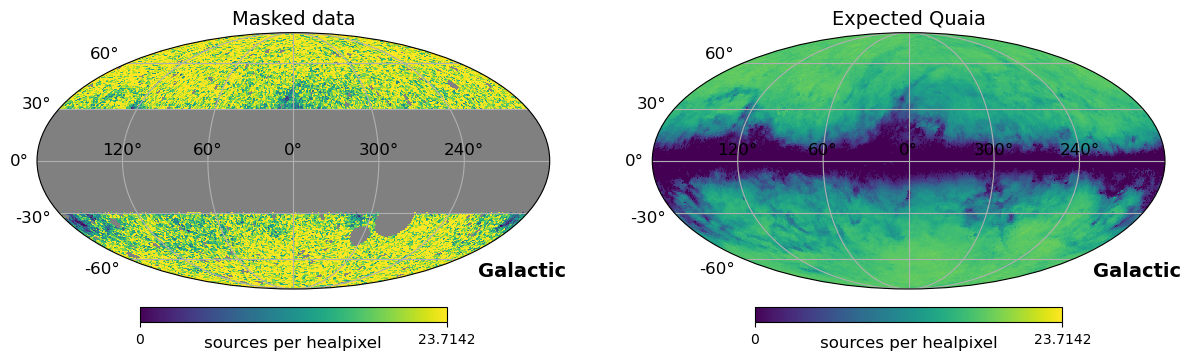

In [30]:
# plot
fig = plt.figure(figsize=(12,4))
mean, std = np.nanmean(N_expected), np.nanstd(N_expected)
kwargs = dict(coord=['C','G'], graticule=True, graticule_labels=True, unit='sources per healpixel',
             min=max([0, mean-2*std]), max=mean+2*std)
projview(masked_datamap, title='Masked data', sub=(1,2,1), **kwargs)
tools.label_coord(plt.gca(), 'Galactic')
projview(N_expected, title='Expected Quaia', sub=(1,2,2), **kwargs)
tools.label_coord(plt.gca(), 'Galactic')

In [65]:
# 3. initialize random number generator rng. Start a loop over N_trial trials

ntrials = 10
max_ell = 5
Cinvs = np.logspace(-2,2,7)
idx_masked = np.isnan(masked_datamap)
print(f"{sum(idx_masked)} masked pixels ({sum(idx_masked)/len(idx_masked)*100:.1f}%)")

# 3a. generate map by rng.poisson(N_expected)

random_map = np.random.poisson(N_expected)

25590 masked pixels (52.1%)


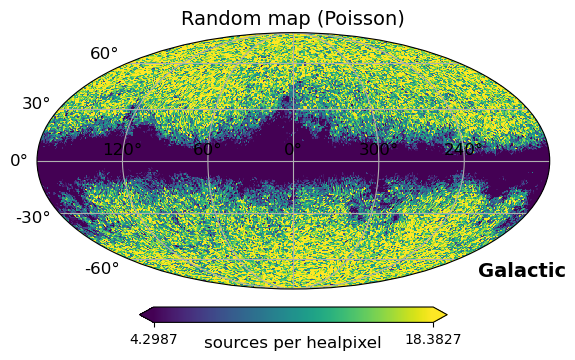

In [66]:
# plot random map
mean, std = np.nanmean(random_map), np.nanstd(random_map)
plot_map(random_map, min=mean-std, max=mean+std, title='Random map (Poisson)', unit='sources per healpixel')

In [67]:
# 3b. Fit a_lm values and get a C_ell measurement at large L_max for each of a few regularization C_inv values.

random_map_to_fit = random_map.copy()
random_map_to_fit[idx_masked] = 0.

Cells = np.empty((len(Cinvs), max_ell))
for i, Cinv in enumerate(Cinvs):
    Cells_this_Cinv = np.empty((ntrials, max_ell))
    for j in range(ntrials):
        print(f"{i+1}.{j+1} of {len(Cinvs)}", end='\r')
        # Cinv: completeness in unmasked pixels, this Cinv in the masked pixels
        Cinv_ = selfunc.copy()
        Cinv_[idx_masked] = Cinv

        ells, Cells_ = Cells_from_alms_fit(random_map_to_fit, Cinv_, max_ell)
        Cells_this_Cinv[j] = Cells_[1:] / Cells_[0]
        
    Cells[i] = np.nanmean(Cells_this_Cinv, axis=0)

Text(0.5, 1.0, 'Quaia shot noise estimates')

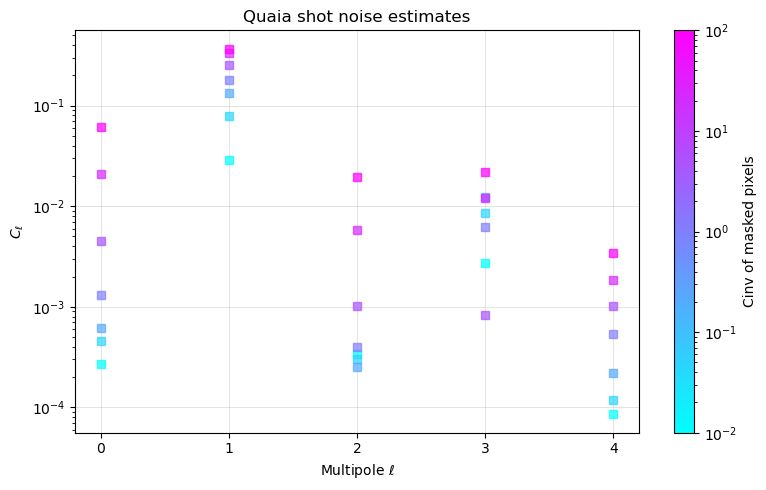

In [69]:
norm = mpl.colors.LogNorm(vmin=min(Cinvs), vmax=max(Cinvs))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)

ells = np.arange(max_ell)

for i, Cinv in enumerate(Cinvs):
    ax.plot(ells, Cells[i], ls='None', marker='s', alpha=0.7, c=smap.to_rgba(Cinv))

ax.semilogy()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xticks(ells.astype(int))
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C_\ell$')
fig.colorbar(smap, ax=ax, label='Cinv of masked pixels')
ax.set_title('Quaia shot noise estimates')